In [1]:
import rebound
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c
import copy

%matplotlib inline

In [2]:
def newtonsMethod(f, fdot, x, precission=0.01):
    while abs(0-f(x)) > precission:
        x = x - f(x)/fdot(x)
    return x

def keplersEq(E, M, e):
    return E - e*np.sin(E)-M

def keplersEqDot(E, M, e):
    return 1 - e*np.cos(E)
    
def guessE(M, e):
    return M + 0.85*e*np.sign(np.sin(M))

def newtonKeplerSolver(M, e, precission=0.0001):
    E = guessE(M, e)
    f = lambda E: keplersEq(E, M, e)
    fdot = lambda E: keplersEqDot(E, M, e)
    return newtonsMethod(f, fdot, E, precission=precission)

In [3]:
mjup2msun_convert = (c.M_jup/c.M_sun).value
mearth2msun_convert = (c.M_earth/c.M_sun).value

star = {"m":0.334}

#exoplanet.eu
#planetc = {"m":0.856*msun2mjup_convert, "e":0.002, "a":0.12959000, "inc":48.07, "omega":225.2, "l":0}
#planetb = {"m":1.938*msun2mjup_convert, "e":0.000, "a":0.20831700, "inc":84.00, "omega":116.7, "l":0}
#planete = {"m":0.045*msun2mjup_convert, "e":0.073, "a":0.33430000, "inc":59.50, "omega":360.0, "l":0}
#planetd = {"m":0.022*msun2mjup_convert, "e":0.081, "a":0.02080665, "inc":50.00, "omega":157.4, "l":0}

# google not best with parameters, look at rivera for i=90 to get enough usable parameters
# https://arxiv.org/pdf/1006.4244.pdf
planetd = {"m":6.83*mearth2msun_convert, "e":0.20700, "a":0.02080665, "inc":59, "omega":234.0, "M":355}
planetc = {"m":0.7142*mjup2msun_convert, "e":0.25591, "a":0.12959000, "inc":59, "omega":48.76, "M":294.59}
planetb = {"m":2.2756*mjup2msun_convert, "e":0.03240, "a":0.20831700, "inc":59, "omega":50.30, "M":0}
planete = {"m":14.6*mearth2msun_convert, "e":0.05500, "a":0.33430000, "inc":59, "omega":239.0, "M":0}

# http://astronomyonline.org/Exoplanets/Gliese876.asp#Gliese876
#planetc = {"m":265.6*mearth2msun_convert, "e":0.2571, "a":0.136044, "inc":53.06, "omega":51.09, "Omega":0}
#planetb = {"m":845.2*mearth2msun_convert, "e":0.0325, "a":0.218627, "inc":53.06, "omega":35.50, "Omega":0}
#planete = {"m":15.80*mearth2msun_convert, "e":0.0300, "a":0.350100, "inc":53.06, "omega":164.1, "Omega":0}
#planetd = {"m":7.550*mearth2msun_convert, "e":0.0570, "a":0.021838, "inc":53.06, "omega":116.0, "Omega":0}
planets = [planetc, planetb, planete, planetd]

# period of closest planet is ~2 days so a 1000 orbits is ~2000 days
# https://rebound.readthedocs.io/en/latest/ipython/Units.html
# the default units are where G=1 (e.g., AU, M⊙, yr/2π)
# so a single timestep is in reference to yr/2pi = 365.256/2pi = 58.132297894 days
# to a good timestep to use is the T_closesPlanet/20 ~ 0.1days or 0.00172021412*dt
# so assuming we started from t=0 we need to integrate to t=0.87208187123 to get 2000 orbits of closest planet

In [26]:
planetd

{'m': 2.0513832252650918e-05,
 'e': 0.207,
 'a': 0.02080665,
 'inc': 59,
 'omega': 234.0,
 'M': 355}

/home/dino/.conda/envs/exoplanets/lib/python3.7/site-packages/rebound/plotting.py:217: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.0, right=0.0
  ax.set_xlim([-lim,lim])
/home/dino/.conda/envs/exoplanets/lib/python3.7/site-packages/rebound/plotting.py:221: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=0.0
  ax.set_ylim([-lim,lim])


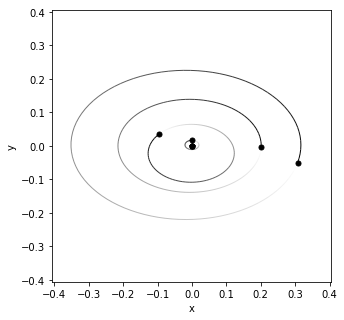

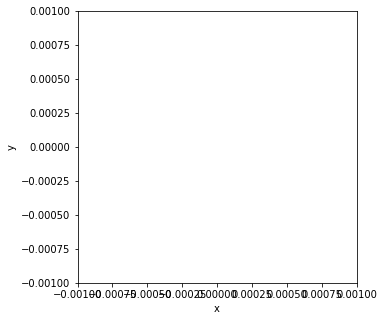

In [4]:
sims = []
for i in range(40, 90, 10):
    sim = rebound.Simulation()
    sim.t = 0
    for planet in planets:
        planet["inc"] = i
        sim.add(**star)
        sim.add(**planet)
    rebound.OrbitPlot(sim)
    sim.integrate(10)
    rebound.OrbitPlot(sim)
    sims.append(sim)    
    break

In [4]:
sim = rebound.Simulation()
sim.add(**star)
sim.add(**planetc)
sim.add(**planetb)
sim.add(**planete)
sim.add(**planetd)
sim.t

0.0

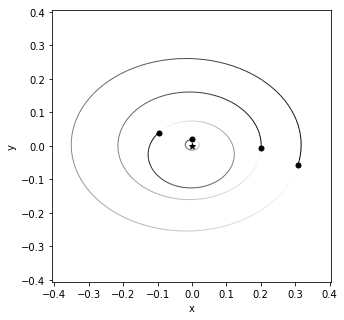

In [21]:
fig = rebound.OrbitPlot(sim)

In [5]:
%time sim.integrate(80)

CPU times: user 3.2 s, sys: 82 µs, total: 3.2 s
Wall time: 3.21 s


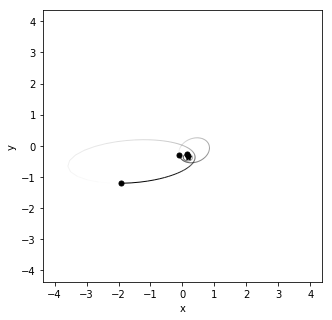

In [6]:
fig = rebound.OrbitPlot(sim)

In [12]:
sim.particles[0]

<rebound.Particle object, m=0.334 x=0.18835345706887313 y=-0.3494131195379932 z=0.28853627258685477 vx=-0.008397578452672505 vy=-0.00838804454829708 vz=0.006926629175968767>